In [9]:
# requirements
import os
import random
import sys
sys.path.insert(0,'..') # to add parent directory
import random
import numpy as np
import matplotlib.pyplot as plt
import xgboost
from utils.data_loader import PatientsRawData
from utils.preprocessing import preprocess_signal
from utils.augment_data import get_augmentation_indexes, augment_data
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay, accuracy_score

# Signal characteristics
This notebook shows how to extract all possible features from the initial signal.
For the simplicity, all feature extraction is demonstrated on a single randomly selected patient.

In [10]:
data = PatientsRawData('../../data/Исходные файлы - рассл/')
data.load_data()
print(f' Data labels: {data.Y} for the total of {len(data.X)} data samples coming from patients: {data.patient}')
print('Explore a random data sample: ')
N = random.randint(0,len(data.X))
data.X[N].head()
data.get_emg_data()

 Data labels: ['Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right'] for the total of 41 data samples coming from patients: ['Аста0201.txt', 'Дюки0202.txt', 'Керш0203.txt', 'Лега0204.txt', 'Сидо0205.txt', 'Фрол0206.txt', 'Хвал0207.txt', 'Черк0208.txt', 'Даке0201.txt', 'Ершо0202.txt', 'Кудр0203.txt', 'Купр0204 .txt', 'Куту0205.txt', 'Лити0206.txt', 'Луче0207.txt', 'Макс0208.txt', 'Миро0209.txt', 'Молю02010.txt', 'Муха02011.txt', 'Соко02012.txt', 'Тихо02013.txt', 'Ерми0201.txt', 'Кова0202.txt', 'Колг0203.txt', 'Медв0204.txt', 'Наза0205.txt', 'Погр0206.txt', 'Савв0207.txt', 'Сави0208.txt', 'Шелу0209.txt', 'Бело0201.txt', 'Гава0202.txt', 'Голу0203.txt', 'Грек0204.txt', 'Губа0205.txt', 'Павл0206.txt', 'Пана0207.t

In [11]:
# convert data to numpy
min_sequence = 10000000000
try:
    data.convert_to_numpy()
except:
    print('already converted, skipping!')
#preprocess all the data
for i in range(len(data.X)):
    one_patient_emg = data.X[i]
    for j, emg_channel in enumerate(one_patient_emg):
        if len(emg_channel)<min_sequence:
            min_sequence = len(emg_channel) 
        processed_signal =  preprocess_signal(emg_channel,  SamplingRate=500,  LF=60, HF=240, frequences_to_filter = [50, 100, 150, 200 ], order_butter=4, save_plot=False,apply_envelope=True) 
        data.X[i][j]=processed_signal # detrend again the obtained signal
    print(f'Pre-processed patient {i}') 
for i in range(len(data.X)):
    data.X[i]=data.X[i][:,:min_sequence] # save to the previous unprocessed signal

Pre-processed patient 0
Pre-processed patient 1
Pre-processed patient 2
Pre-processed patient 3
Pre-processed patient 4
Pre-processed patient 5
Pre-processed patient 6
Pre-processed patient 7
Pre-processed patient 8
Pre-processed patient 9
Pre-processed patient 10
Pre-processed patient 11
Pre-processed patient 12
Pre-processed patient 13
Pre-processed patient 14
Pre-processed patient 15
Pre-processed patient 16
Pre-processed patient 17
Pre-processed patient 18
Pre-processed patient 19
Pre-processed patient 20
Pre-processed patient 21
Pre-processed patient 22
Pre-processed patient 23
Pre-processed patient 24
Pre-processed patient 25
Pre-processed patient 26
Pre-processed patient 27
Pre-processed patient 28
Pre-processed patient 29
Pre-processed patient 30
Pre-processed patient 31
Pre-processed patient 32
Pre-processed patient 33
Pre-processed patient 34
Pre-processed patient 35
Pre-processed patient 36
Pre-processed patient 37
Pre-processed patient 38
Pre-processed patient 39
Pre-proces

## Select a random patient, and display his data

In [12]:
n = random.randint(0,len(data.Y))
patient = data.X[n]
patient_label = data.Y[n]
print(f"Selected patient {patient_label} {data.patient[n]}")

Selected patient Right Голу0203.txt


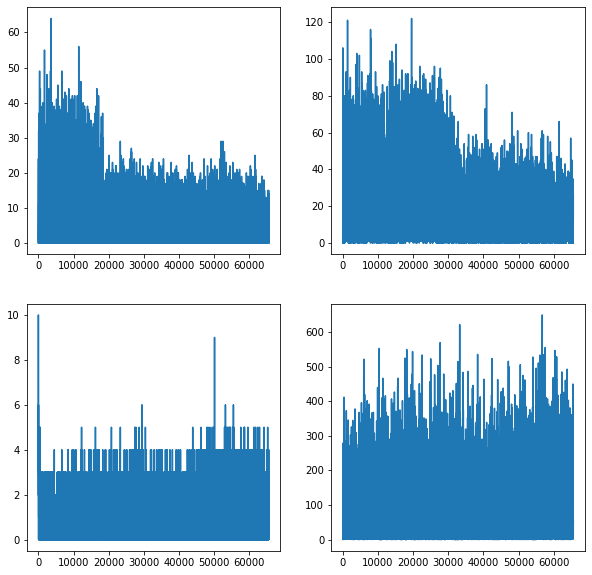

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
i = 0
for row in ax:
    for col in row:
        col.plot(patient[i])
        i+=1
plt.show()

# Features on a single signal

### Amplitudes and Frequences

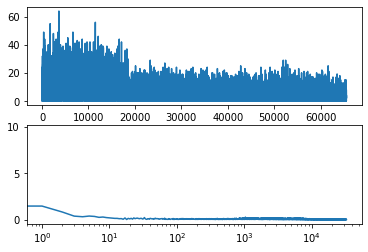

In [14]:
# get all stats about the signal amplitude, phase https://stackoverflow.com/questions/51298604/calculating-amplitude-from-np-fft

t0 = 0
t1 = 1

plt.subplot(2, 1, 1)
plt.plot(patient[0])
n_samples = len(patient[0])

np_fft = np.fft.fft(patient[0])
amplitudes = 2 / n_samples * np.abs(np_fft) 
frequencies = np.fft.fftfreq(n_samples) * n_samples * 1 / (t1 - t0)

plt.subplot(2, 1, 2)
plt.semilogx(frequencies[:len(frequencies) // 2], amplitudes[:len(np_fft) // 2])

plt.show()

In [15]:
amplitudes_features = [np.mean(amplitudes), np.max(amplitudes), np.min(amplitudes)]
amplitudes_features
# or maybe analyze all the peaks in the beginning? 

[0.02424026791088602, 9.677645623665748, 4.52425073011603e-05]

### Signal moments
Mean, variance, skewness, and kurtosis, and also high-order moments are moments beyond 4th-order moments.
For Example, E(X), E(X²), E(X³), E(X⁴),…, etc.
More about moments [here](https://en.wikipedia.org/wiki/Moment_(mathematics)
The library used for signal moments calculations in python is [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.moment.html)

In [16]:
import scipy

In [20]:
moments = []
for i in range(1,6):
    moments.append(scipy.stats.moment(patient[0], moment=i, axis=0, nan_policy='propagate'))
print(moments)

[0.0, 21.92056049284955, 275.1389076181324, 7248.317992009745, 213614.69457019982]


In [22]:
# skewness
skew = scipy.stats.skew(patient[0])
print(skew)

2.6808624198955524


In [28]:
# mean value signal
mean_scipy.stats.tmean(patient[0])

4.838822811832876

In [29]:
# variation
scipy.stats.variation(patient[0])

0.9675782734027263

In [31]:
# kurtosis
scipy.stats.kurtosis(patient[0])

12.08460453463374

## Entropy 

In [34]:
scipy.stats.entropy(patient[0])

10.718524329091734

##  SPECTRUM ANALYSIS WINDOWS
TODO:
From [here](https://www.dsprelated.com/freebooks/sasp/Spectrum_Analysis_Windows.html)
and [here](https://github.com/unpingco/Python-for-Signal-Processing)

# Features between signals

Various synchrony measures are studied in the context of AD diagnosis, including the correlation coefficient, mean-square and phase coherence, Granger causality, phase synchrony indices, information-theoretic divergence measures, state space based measures, and the recently proposed stochastic event synchrony measures.

: 